# Titanic Survivors

The data has been split into train.csv and test.csv.

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

---

**Data Dictionary**
|Variable	|Definition	|Key|
| :--: |:--:|:--:|
|survival|	Survival|	0 = No, 1 = Yes|
|pclass|	Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	|
|Age	|Age in years	|
|sibsp	|# of siblings / spouses	|
|parch	|# of parents / children	|
|ticket	|Ticket number	|
|fare	|Passenger fare	|
|cabin	|Cabin number	|
|embarked	|Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton|


### Approach:

1. Start with explorative data analysis to understand the structure of the data, the distribution of variables, and the relationships between variables.

2. Clean the data and deal with missing values. Transform categorical variables into a form that can be used in a machine learning model.

4. Create a model, train it on the data, and evaluate its performance.

5. Fine-tune the model to improve its performance. Try feature engineering.

In [96]:
import pandas as pd
import numpy as np  

In [97]:
train = pd.read_csv('titanic/train.csv') # , index_col='PassengerId'
test = pd.read_csv('titanic/test.csv')

## A simple benchmark: what if only women survive

'The base model'

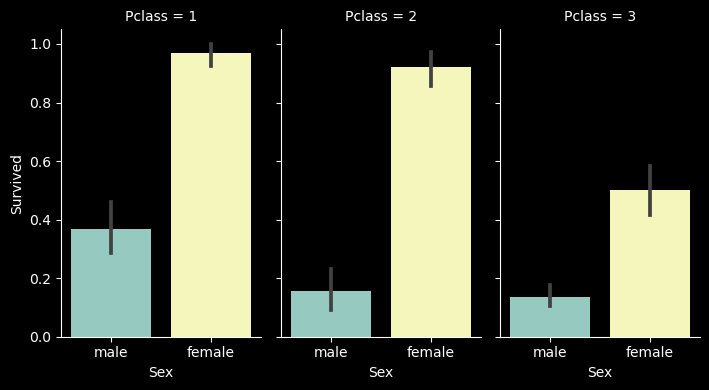

In [98]:
sns.catplot(
    data=train, x="Sex", y="Survived", col="Pclass",
    kind="bar", height=4, 
    aspect=.6,
)

In [99]:
train.groupby('Sex')['Survived'].value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [100]:
train.groupby('Sex').count()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Sex,,,,,,,,,,,
female,314,314,314,314,261,314,314,314,314,97,312
male,577,577,577,577,453,577,577,577,577,107,577


Simpler is:

In [101]:
pd.pivot_table(train, index='Survived', columns='Sex', values='Ticket', aggfunc ='count')

Sex,female,male
Survived,,
0,81,468
1,233,109


In [102]:
f'{233 / 314 * 100:.0f}% of women survived, and {109 / 577 * 100:.0f}% of men'

'74% of women survived, and 19% of men'

So a confusion matrix:

[tn, fp,

fn, tp]

468, 81

109, 233

In [103]:
correct = 233 + 468 # all the 'true' values: it is true that many women survived and many men died
total = 468 + 81 + 109 + 233
f'This gives an accuracy score of {correct / total * 100:.0f}%'

'This gives an accuracy score of 79%'

# Exploring the data

In [104]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [105]:
import seaborn as sns 

# sns.pairplot(train, diag_kind='kde') # doesn't show much

Multi-correlation

In [106]:
corrs = train.drop('Survived', axis=1).corr(numeric_only=True)
corrs

,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Pclass,-0.035144,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,-0.549500,0.096067,0.159651,0.216225,1.000000


<Axes: >

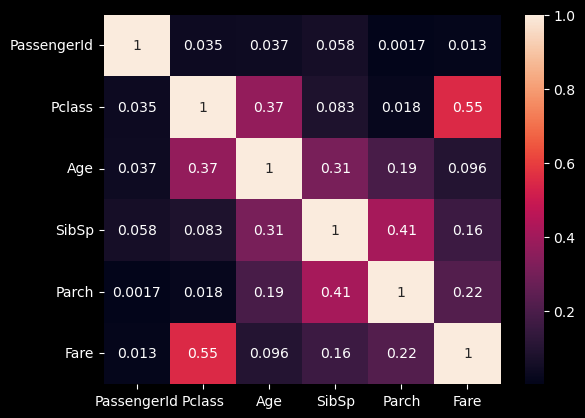

In [107]:
sns.heatmap(data=corrs.abs(), annot=True)

# Cleaning and transforming the data
## Set types

In [108]:
train['Pclass'] = train['Pclass'].astype('category')
train['Name'] = train['Name'].astype('string')
train['Sex'] = train['Sex'].astype('category')
train['Embarked'] = train['Embarked'].astype('category')
train['Ticket'] = train['Ticket'].astype('string')
train['Cabin'] = train['Cabin'].astype('string')

In [109]:
test['Pclass'] = test['Pclass'].astype('category')
test['Name'] = test['Name'].astype('string')
test['Sex'] = test['Sex'].astype('category')
test['Embarked'] = test['Embarked'].astype('category')
test['Ticket'] = test['Ticket'].astype('string')
test['Cabin'] = test['Cabin'].astype('string')

In [110]:
train[['Fare']].astype('Float32')
test[['Fare']].astype('Float32')

,Fare
0,7.8292
1,7.0
2,9.6875
3,8.6625
4,12.2875
...,...
413,8.05
414,108.900002
415,7.25
416,8.05


## Clean NaNs

In [111]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [112]:
mean_age = train['Age'].mean()
mode_embarked = train['Embarked'].mode()[0]  # The [0] is used because the mode() function returns a series, and we just want to get the first (and in many cases, the only) value.
mean_age, mode_embarked

(29.69911764705882, 'S')

In [113]:
train = train.copy()
train['Embarked'] = train['Embarked'].fillna(mode_embarked)
train['Age'] = train['Age'].fillna(mean_age)


test = test.copy()
test['Embarked'] = test['Embarked'].fillna(mode_embarked)
test['Age'] = test['Age'].fillna(mean_age)

In [114]:
# train.drop(['Cabin'], axis=1) # I'll just exclude it from the features
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Filter on values within brackets:
 
    test[test['Embarked'].isna()]
 
checks all lines where value is NaN, not how you specify the column first, then the index by repeating `df[]` inside the brackets

In [115]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [116]:
mean_fare = test['Fare'].mean()
test['Fare'].fillna(mean_fare, inplace=True)

Alternatively: sklearn has a `simpleImputer` amoung its `imputers` which takes the argument `simpleImputer(strategy='mean')` to fill all NaNs.

If the age is estimated, is it in the form of xx.5

- Note the formula though: the column Age is selected, and of the index any value where the remainder is 0.5. I then counted those.
  
```python
train['Age'][train['Age'] % 1 == 0.5].count()
```

In [117]:
train.groupby('Survived')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,30.415100,12.457370,1.00,23.0,29.699118,35.0,74.0
1,342.0,28.549778,13.772498,0.42,21.0,29.699118,35.0,80.0


In [118]:
pd.pivot_table(train, index= 'Survived', values= ['Age'])

,Age
Survived,
0,30.415100
1,28.549778


## Categories to dummies

pandas has a `get_dummies()` function.

from sklearn.preprocessing import `LabelEncoder`
    - can still get treated as numerical 
    
from sklearn.preprocessing import `OneHotEncoder`

## From Kaggle

With this [first one also on youtube](https://www.kaggle.com/kenjee/titanic-project-example) I found it impressive how he explored the data 
- as to understand which variables are categorical and which are numerical
- to understand the distribution - recall how least squares *assumes* normal distribution
- and he uses pivot tables to see every variable in relation to 'survived'

(The [second one](https://www.kaggle.com/code/vinothan/titanic-model-with-90-accuracy/notebook) had some neat tricks turning the the feature.importances into series and then a plot. But that's for later.)

In [119]:
df_num = train[['Age','SibSp','Parch','Fare']]
df_cat = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]


import matplotlib.pyplot as plt
#distributions for all numeric variables 
# for i in df_num.columns:
#     plt.hist(df_num[i])
#     plt.title(i)
#     plt.show()

In [120]:
axs # .flatten() is a numpy function that transforms 2D arrays into 1D arrays to allow looping.

array([<Axes: title={'center': 'Survived'}, ylabel='Survived'>,
       <Axes: title={'center': 'Pclass'}, ylabel='Pclass'>,
       <Axes: title={'center': 'Sex'}, ylabel='Sex'>,
       <Axes: title={'center': 'Ticket'}, ylabel='Ticket'>,
       <Axes: title={'center': 'Cabin'}, ylabel='Cabin'>,
       <Axes: title={'center': 'Embarked'}, ylabel='Embarked'>],
      dtype=object)

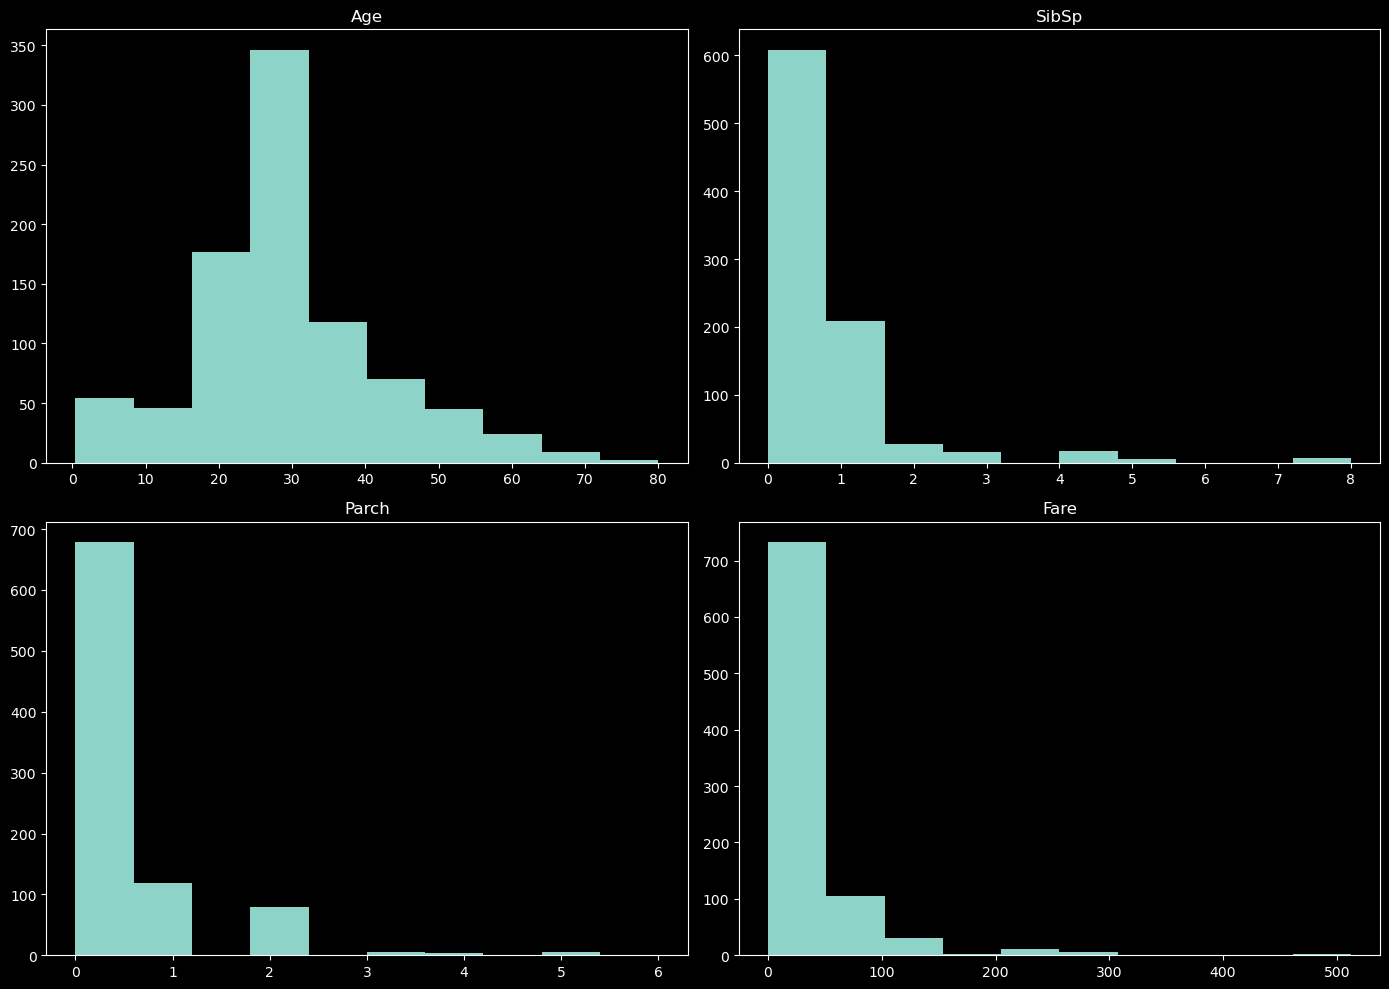

In [121]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10)) 


# Flatten the axes array, so we can easily iterate over it
axs = axs.flatten()

# Iterate over the columns and the axes
for ax, col in zip(axs, df_num.columns):
    ax.hist(df_num[col])
    ax.set_title(col)
plt.tight_layout()  # Adjust the layout so everything fits nicely
plt.show()

In [122]:
pd.pivot_table(train, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.415100,22.117887,0.329690,0.553734
1,28.549778,48.395408,0.464912,0.473684


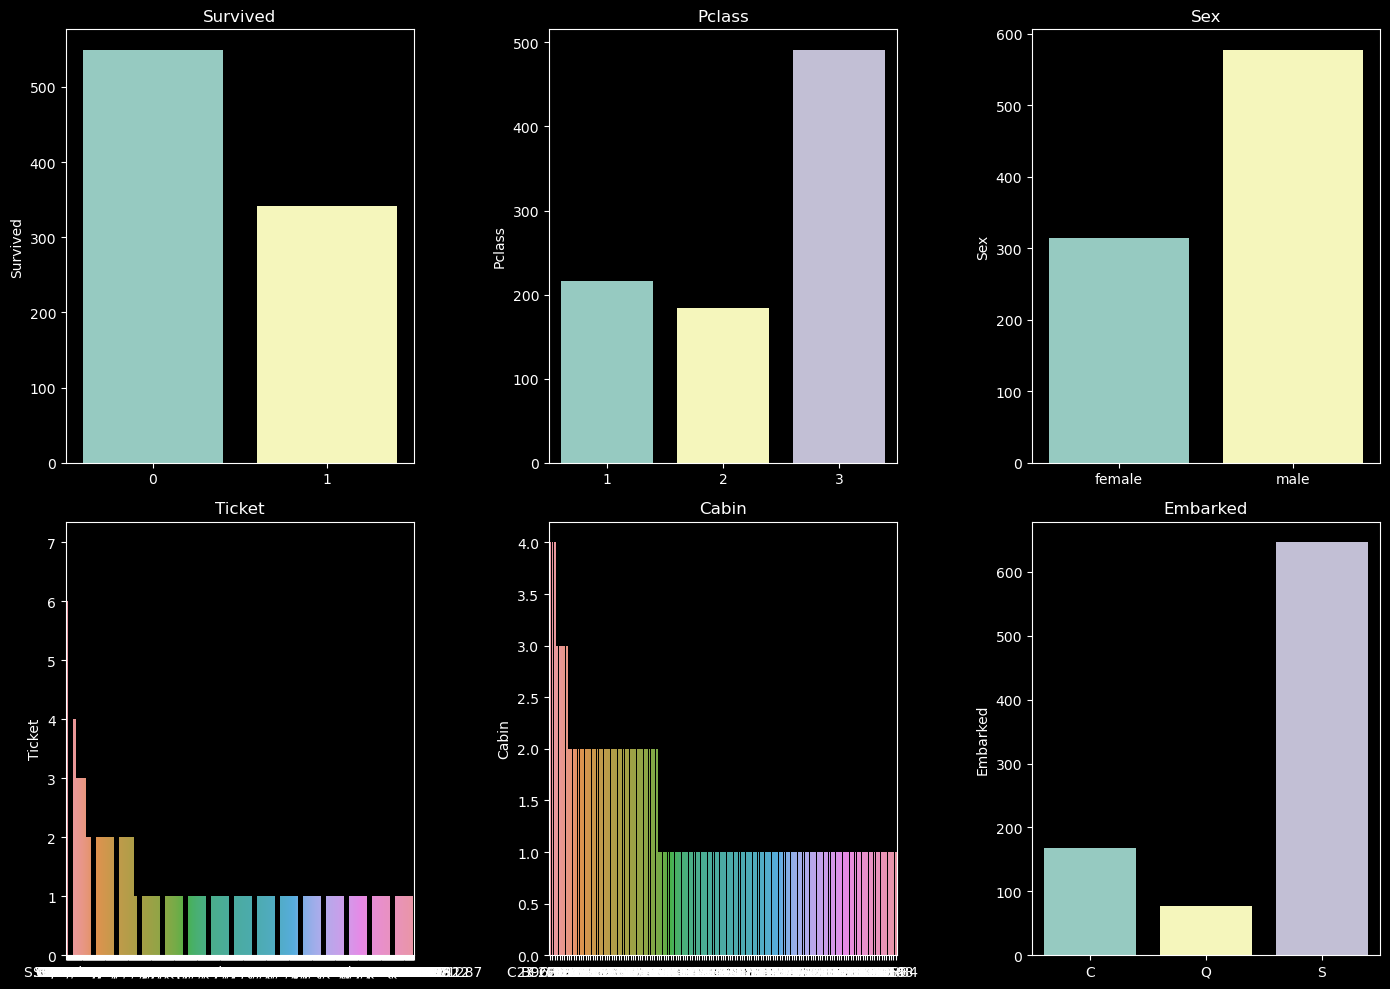

In [123]:
# And the same with bar plots and value counts for the numerical values:
fig, axs = plt.subplots(2,3, figsize=(14,10))

axs = axs.flatten()

for ax,col in zip(axs, df_cat.columns):        
    sns.barplot(x=df_cat[col].value_counts().index, y=df_cat[col].value_counts(), ax=ax) # note the ax=ax to point sns to the axes
    ax.set_title(col)
    
plt.tight_layout()  # Adjust the layout so everything fits nicely
plt.show()

In [124]:
pd.pivot_table(train, index='Survived', values=['Pclass','Sex','Ticket','Cabin','Embarked'], aggfunc ='count')

,Cabin,Embarked,Pclass,Sex,Ticket
Survived,,,,,
0,68,549,549,549,549
1,136,342,342,342,342


# Feature Engineering

1. You can create a "Title" feature from the "Name" feature, which might contain valuable information about social status, profession, etc.

2. Splitting up "Sex" into "Man", "Woman", and "Child" as you suggested could be useful, especially if children have a different survival rate.

3. You could convert "Age" into bins (ranges of ages) or convert it into a categorical feature such as "Child", "Adult", "Elderly".

4. "Cabin" could be split into two features, one for the cabin number and one for the deck (A, B, C, D, E, F, G, T).

5. Creating a feature for family size based on "SibSp" (number of siblings/spouses aboard) and "Parch" (number of parents/children aboard).

6. You might also want to take a closer look at "Ticket" and "Fare" to see if they contain any useful information.

**Model Parameter Tuning**
- look at learning rate, max depth, etc

**Ensembling and cross validation**

...

## 1. Extract titles

In [125]:
train['Title'] = train['Name'].str.extract('([A-Za-z]+)\.')
print(train['Title'].unique())

<StringArray>
[      'Mr',      'Mrs',     'Miss',   'Master',      'Don',      'Rev',
       'Dr',      'Mme',       'Ms',    'Major',     'Lady',      'Sir',
     'Mlle',      'Col',     'Capt', 'Countess', 'Jonkheer']
Length: 17, dtype: string


In [126]:
# Group uncommon titles
train['Title'] = train['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

print(train['Title'].value_counts())

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: Int64


In [127]:
test['Title'] = test['Name'].str.extract('([A-Za-z]+)\.')

test['Title'] = test['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

## Ages to Groups

> Uses pandas.cut() to convert ages to ranges.

To segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. 

For example, cut could convert ages to groups of age ranges. Supports binning into an equal number of bins, or a pre-specified array of bins.

In [128]:
# Define the bin edges and labels
bins = [0, 15, 25, 33, 58]
labels = ['Child', 'Teenager', 'Adult', 'Senior']

# Create a new feature 'AgeGroup' by binning the 'Age' feature
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels)

test['AgeGroup'] = pd.cut(test['Age'], bins=bins, labels=labels)

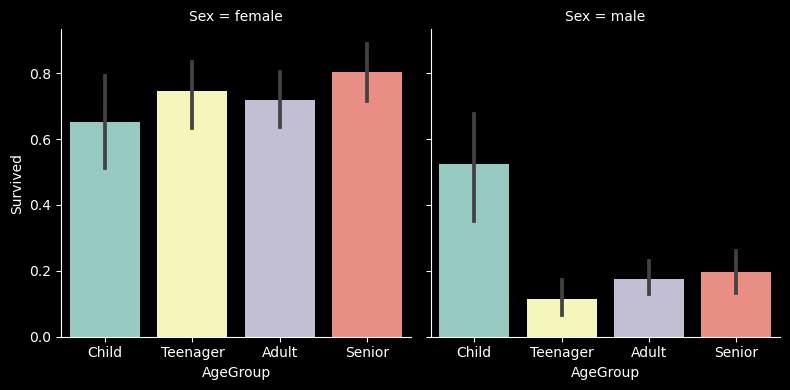

In [129]:
sns.catplot(
    data=train, x="AgeGroup", y="Survived", col="Sex",
    kind="bar", height=4,     
)

In [130]:
train[train['Age'] < 15].groupby('Survived')['Age'].describe() # filters the df on age > 7, then groups by survived, 

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,33.0,6.984848,4.280196,1.00,2.0,8.0,10.0,14.5
1,45.0,4.959333,4.191984,0.42,1.0,4.0,7.0,14.0


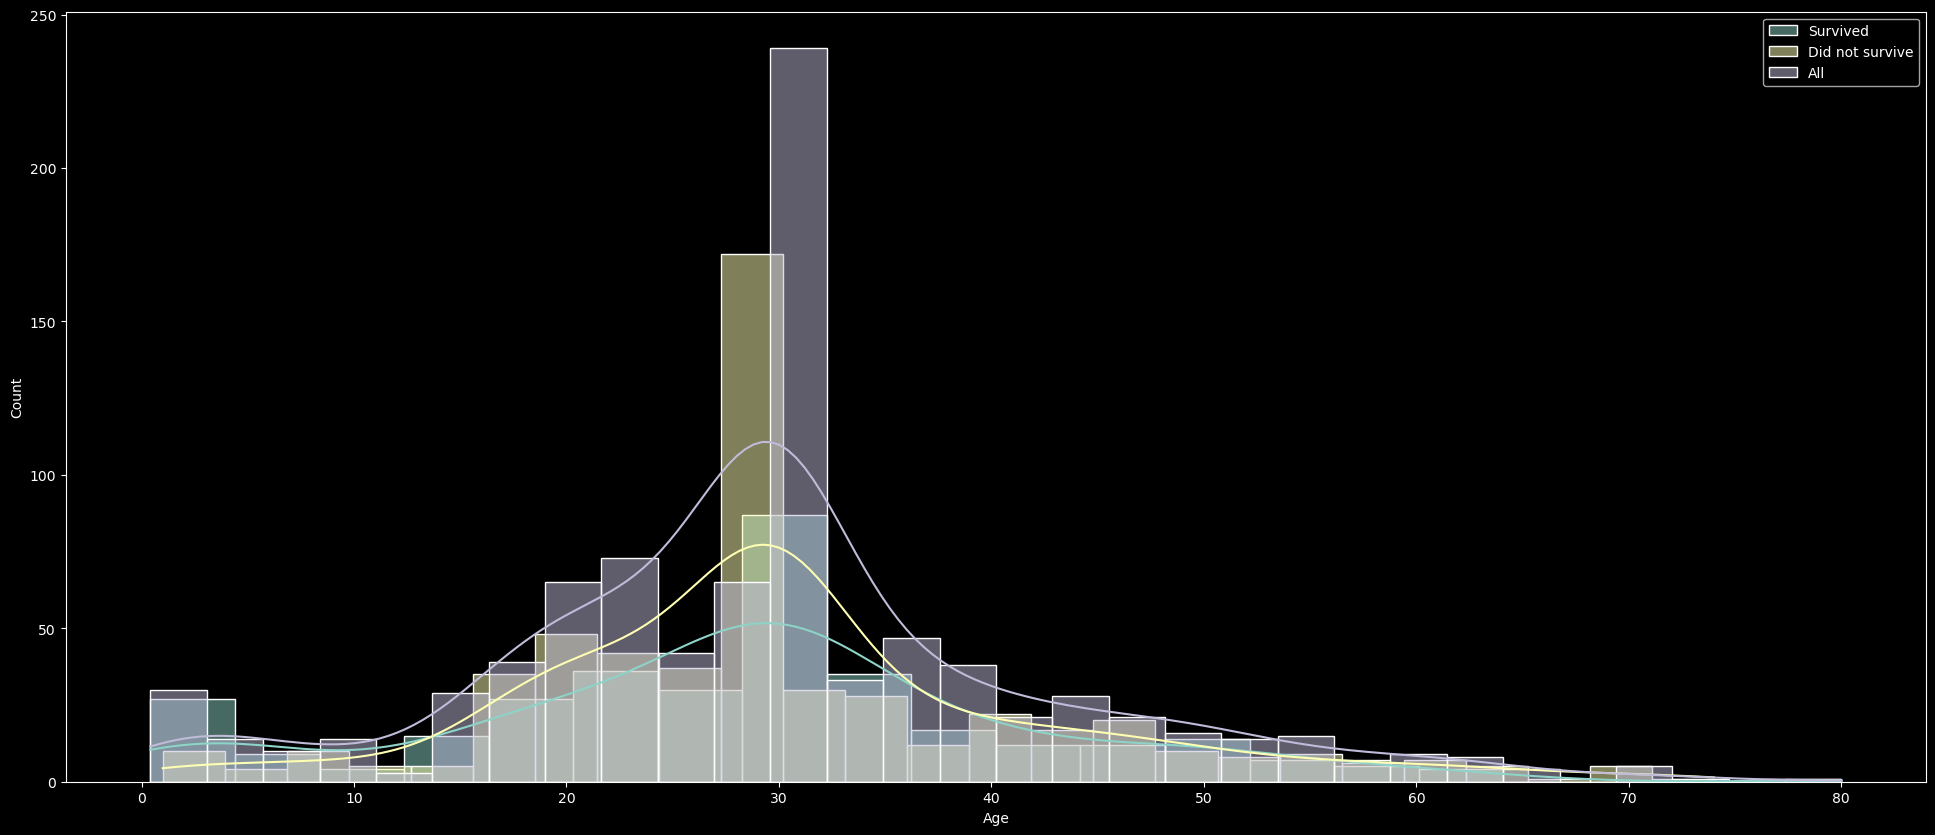

In [131]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 10))

sns.histplot(train[train['Survived'] == 1]['Age'], label='Survived', kde=True)
sns.histplot(train[train['Survived'] == 0]['Age'], label='Did not survive', kde=True)
sns.histplot(train['Age'], label='All', kde=True)

plt.legend()

## 4. Cabin info

In [132]:
cabins = train[['Cabin', 'Survived']][train['Cabin'].notna()].sort_values(by='Cabin')

In [133]:
cabins.sample(10)

,Cabin,Survived
742,B57 B59 B63 B66,1
857,E17,1
195,B80,1
809,E8,1
88,C23 C25 C27,1
662,E58,0
486,C93,1
835,E49,1
779,B3,1
215,D36,1


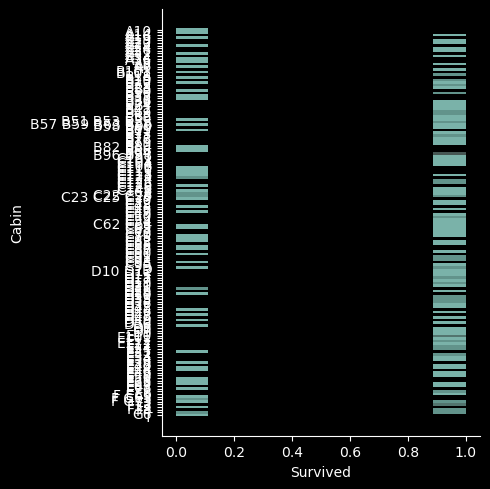

In [134]:
sns.displot(cabins, x=cabins['Survived'], y=cabins['Cabin'])

In [135]:
train['Cabin_prefix'] = train['Cabin'].str.extract(r'([A-Z])')

test['Cabin_prefix'] = test['Cabin'].str.extract(r'([A-Z])')

test['Cabin_prefix'].value_counts()

C    35
B    18
D    13
E     9
F     8
A     7
G     1
Name: Cabin_prefix, dtype: Int64

In [136]:
# train['Cabin_prefix'] = train['Cabin_prefix'].replace(['F', 'G', 'T'], 'FGT')
# test['Cabin_prefix'] = test['Cabin_prefix'].replace(['F', 'G', 'T'], 'FGT')

In [137]:
train['Cabin_prefix'] = train['Cabin_prefix'].fillna('Other')
test['Cabin_prefix'] = test['Cabin_prefix'].fillna('Other')

In [138]:
# There is only one passenger on deck T and the test set has no values for deck T.
# The closest category is deck 'A' (checking on deck arrangements image found via Google), so
# we change all occurrences of T to A.
idx = train[train['Cabin_prefix'] == 'T'].index
train.loc[idx, 'Cabin_prefix'] = 'A'

## Some of the classes have very few values, we group adjacent classes together.
train['Cabin_prefix'] = train['Cabin_prefix'].replace(['B', 'D', 'E'], 'BDE')
train['Cabin_prefix'] = train['Cabin_prefix'].replace(['A', 'G'], 'AG')
train['Cabin_prefix'] = train['Cabin_prefix'].replace(['C', 'F'], 'FG')

train['Cabin_prefix'] = train['Cabin_prefix'].replace(['B', 'D', 'E'], 'BDE')
train['Cabin_prefix'] = train['Cabin_prefix'].replace(['A', 'G'], 'AG')
train['Cabin_prefix'] = train['Cabin_prefix'].replace(['C', 'F'], 'FG')

In [139]:
idx = test[test['Cabin_prefix'] == 'T'].index
test.loc[idx, 'Cabin_prefix'] = 'A'

## Some of the classes have very few values, we group adjacent classes together.
test['Cabin_prefix'] = test['Cabin_prefix'].replace(['B', 'D', 'E'], 'BDE')
test['Cabin_prefix'] = test['Cabin_prefix'].replace(['A', 'G'], 'AG')
test['Cabin_prefix'] = test['Cabin_prefix'].replace(['C', 'F'], 'FG')

test['Cabin_prefix'] = test['Cabin_prefix'].replace(['B', 'D', 'E'], 'BDE')
test['Cabin_prefix'] = test['Cabin_prefix'].replace(['A', 'G'], 'AG')
test['Cabin_prefix'] = test['Cabin_prefix'].replace(['C', 'F'], 'FG')

#### Cabin numbers aren't super useful...

In [140]:
train['Cabin_nr'] = train['Cabin'].str.extract(r'\w([\d]*)')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,Cabin_prefix,Cabin_nr
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,<NA>,S,Mr,Teenager,Other,<NA>
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Mrs,Senior,FG,85
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,<NA>,S,Miss,Adult,Other,<NA>
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Mrs,Senior,FG,123
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,<NA>,S,Mr,Senior,Other,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,<NA>,S,Rare,Adult,Other,<NA>
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,Miss,Teenager,BDE,42
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,<NA>,S,Miss,Adult,Other,<NA>
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,Mr,Adult,FG,148


In [141]:
cabins_nrs = train['Cabin'].str.extract(r'\w([\d]*)')
cabins_nrs

,0
0,<NA>
1,85
2,<NA>
3,123
4,<NA>
...,...
886,<NA>
887,42
888,<NA>
889,148


In [142]:
# train['Cabin_nr'] = pd.cut(x=train['Cabin'].str.extract(r'\w([\d]*)')[0], bins=10)
# train

## FamilySize

In [143]:
train[['SibSp', 'Parch', 'Survived']].sort_values(by='SibSp', ascending=False)

,SibSp,Parch,Survived
159,8,2,0
180,8,2,0
201,8,2,0
792,8,2,0
846,8,2,0
...,...,...,...
359,0,0,1
362,0,1,0
363,0,0,0
365,0,0,0


In [144]:
train['FamilySize'] = train['SibSp'] + train['Parch']

test['FamilySize'] = test['SibSp'] + test['Parch']

In [145]:
# Create family size feature
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# Create family size groupings
train['fam_size'] = pd.cut(train.FamilySize, [0,1,4,7,11], labels=['single',
                           'small', 'large', 'very_large'])
test['fam_size'] = pd.cut(test.FamilySize, [0,1,4,7,11], labels=['single',
                           'small', 'large', 'very_large'])

## Fare

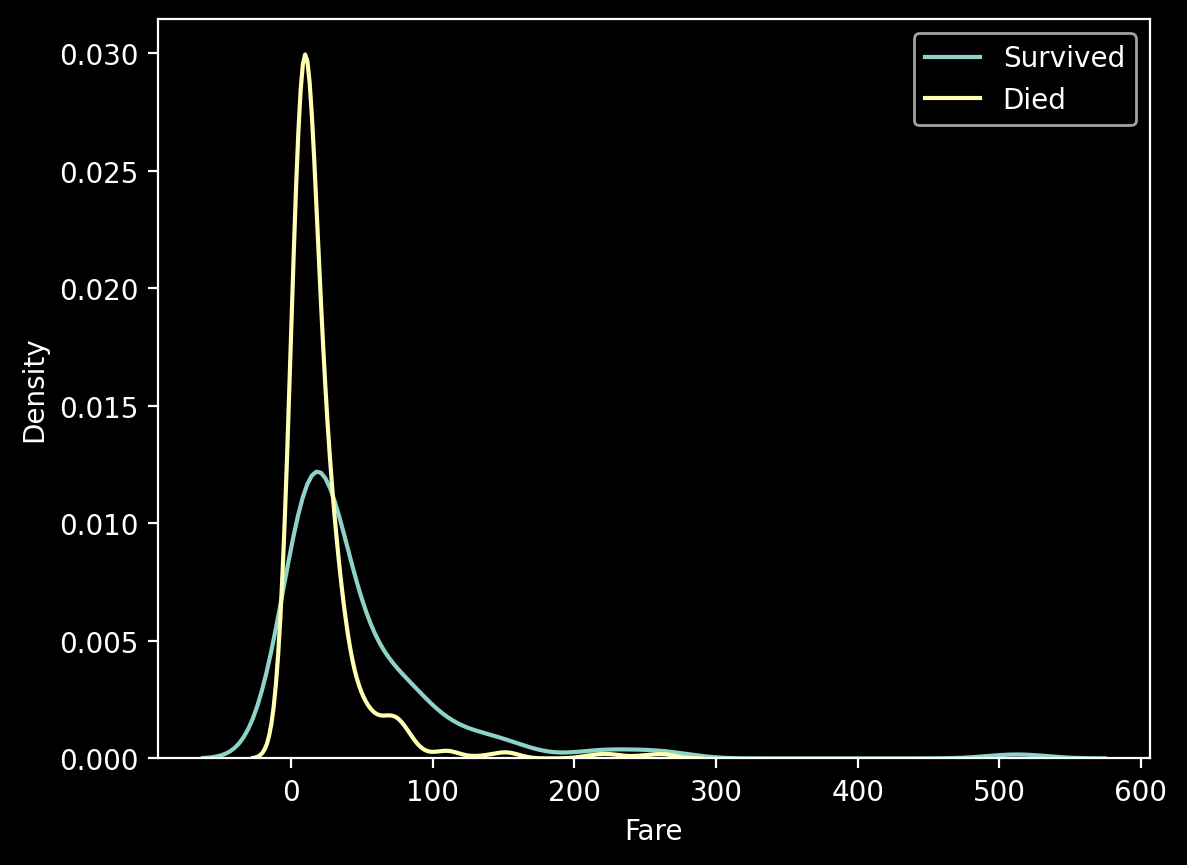

In [146]:
plt.figure(dpi=200)
sns.kdeplot(train[train['Survived'] == 1]['Fare'], label='Survived')
sns.kdeplot(train[train['Survived'] == 0]['Fare'], label='Died')

plt.legend()

In [147]:
train[['Fare', 'Pclass']].sample(10)

,Fare,Pclass
852,15.2458,3
416,32.5000,2
761,7.1250,3
315,7.8542,3
355,9.5000,3
115,7.9250,3
734,13.0000,2
24,21.0750,3
412,90.0000,1
121,8.0500,3


## Ticket

In [148]:
train['Ticket_'] = train['Ticket'].str.extract(r'([\d]*)') # .sample(10)
train['Ticket_'] = pd.to_numeric(train['Ticket_'])

In [149]:
train['Ticket_'].max()

3101298.0

<Axes: xlabel='Ticket_', ylabel='PassengerId'>

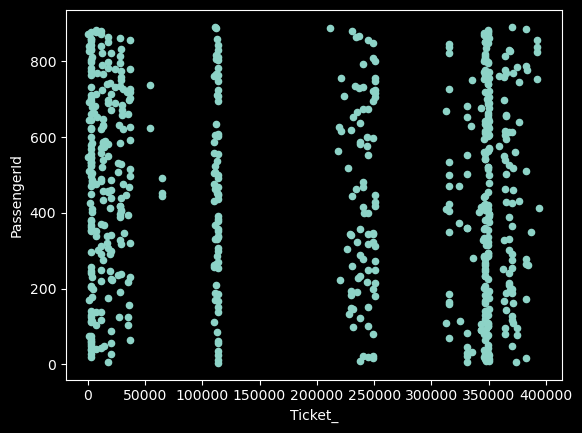

In [150]:
train[train['Ticket_'] < 400000].plot.scatter(x='Ticket_', y='PassengerId') # after chopping off the numbers over 3 million

In [151]:
train['Ticket_d'] = pd.cut(x=train['Ticket_'], bins=[0, 100000, 200000, 300000, 400000, 3102000])
train['Ticket_d']

0                       NaN
1                       NaN
2                       NaN
3      (100000.0, 200000.0]
4      (300000.0, 400000.0]
               ...         
886    (200000.0, 300000.0]
887    (100000.0, 200000.0]
888                     NaN
889    (100000.0, 200000.0]
890    (300000.0, 400000.0]
Name: Ticket_d, Length: 891, dtype: category
Categories (5, interval[int64, right]): [(0, 100000] < (100000, 200000] < (200000, 300000] < (300000, 400000] < (400000, 3102000]]

In [152]:
train['Ticket_d'].value_counts()

(300000, 400000]     256
(0, 100000]          230
(200000, 300000]      87
(100000, 200000]      72
(400000, 3102000]     16
Name: Ticket_d, dtype: int64

In [153]:
test['Ticket_'] = test['Ticket'].str.extract(r'([\d]*)')
test['Ticket_'] = pd.to_numeric(test['Ticket_'])
test['Ticket_d'] = pd.cut(x=test['Ticket_'], bins=[0, 100000, 200000, 300000, 400000, 3102000])

# Scale

Not useful for decision trees and random forest

In [154]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# Fare_train = train['Fare'].values.reshape(-1, 1)
# Fare_test = test['Fare'].values.reshape(-1, 1)

# train['Fare_train_scaled'] = scaler.fit_transform(Fare_train,train['Survived'])  
# test['Fare_test_scaled'] = scaler.transform(Fare_test)

# Split

In [155]:
from sklearn.model_selection import train_test_split

X_all = train.drop(['Survived'], axis=1)
y_all = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True)

# y = y_train

# Apply features

In [156]:
cats = ['Sex', 'Pclass', 'Cabin_prefix', 'Embarked', 'Title', 'AgeGroup','FamilySize', 'Ticket_d', 'Fare']

X_train_dummies = pd.get_dummies(X_train[cats])
X_test_dummies = pd.get_dummies(X_test[cats])

> I put fare with he cats

In [157]:
# X_train_dummies['Fare'] = X_train['Fare_train_scaled']
# X_test_dummies['Fare'] = X_test['Fare_train_scaled']

In [158]:
X_train_dummies.columns, X_test_dummies.columns

(Index(['FamilySize', 'Fare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
        'Pclass_3', 'Cabin_prefix_AG', 'Cabin_prefix_BDE', 'Cabin_prefix_FG',
        'Cabin_prefix_Other', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
        'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
        'AgeGroup_Child', 'AgeGroup_Teenager', 'AgeGroup_Adult',
        'AgeGroup_Senior', 'Ticket_d_(0, 100000]', 'Ticket_d_(100000, 200000]',
        'Ticket_d_(200000, 300000]', 'Ticket_d_(300000, 400000]',
        'Ticket_d_(400000, 3102000]'],
       dtype='object'),
 Index(['FamilySize', 'Fare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
        'Pclass_3', 'Cabin_prefix_AG', 'Cabin_prefix_BDE', 'Cabin_prefix_FG',
        'Cabin_prefix_Other', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
        'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
        'AgeGroup_Child', 'AgeGroup_Teenager', 'AgeGroup_Adult',
        'AgeGroup_Senior', 'Ticket_d_(0, 100000

In [159]:
X_train_dummies = X_train_dummies.drop(['Embarked_Q',
    # 'FamilySize', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
#         'Pclass_3', 'Cabin_prefix_E', 'Cabin_prefix_Other', 'Title_Master', 'Title_Miss', 'Title_Mr',
#         'Title_Mrs', 'AgeGroup_Child', 'AgeGroup_Teenager','AgeGroup_Senior', 'Ticket_d_(0, 100000]',
#         'Ticket_d_(300000, 400000]'
    ], axis=1)

X_test_dummies = X_test_dummies.drop(['Embarked_Q',
    # 'FamilySize', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
#         'Pclass_3', 'Cabin_prefix_E', 'Cabin_prefix_Other', 'Title_Master', 'Title_Miss', 'Title_Mr',
#         'Title_Mrs', 'AgeGroup_Child', 'AgeGroup_Teenager','AgeGroup_Senior', 'Ticket_d_(0, 100000]',
#         'Ticket_d_(300000, 400000]'
    ], axis=1)


# For real: without split

this trains on the whole train dataset

In [160]:
X_all_dummies = pd.get_dummies(X_all[cats])
# X_all_dummies['Fare'] = X_all['Fare_train_scaled']

In [161]:
X_result = pd.get_dummies(test[cats])

# X_result['Fare'] = test['Fare_test_scaled']

In [162]:
X_all_dummies.columns, X_result.columns

(Index(['FamilySize', 'Fare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
        'Pclass_3', 'Cabin_prefix_AG', 'Cabin_prefix_BDE', 'Cabin_prefix_FG',
        'Cabin_prefix_Other', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
        'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
        'AgeGroup_Child', 'AgeGroup_Teenager', 'AgeGroup_Adult',
        'AgeGroup_Senior', 'Ticket_d_(0, 100000]', 'Ticket_d_(100000, 200000]',
        'Ticket_d_(200000, 300000]', 'Ticket_d_(300000, 400000]',
        'Ticket_d_(400000, 3102000]'],
       dtype='object'),
 Index(['FamilySize', 'Fare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
        'Pclass_3', 'Cabin_prefix_AG', 'Cabin_prefix_BDE', 'Cabin_prefix_FG',
        'Cabin_prefix_Other', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
        'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
        'AgeGroup_Child', 'AgeGroup_Teenager', 'AgeGroup_Adult',
        'AgeGroup_Senior', 'Ticket_d_(0, 100000

In [163]:
X_result.isna().sum().sort_values()

FamilySize                    0
Ticket_d_(200000, 300000]     0
Ticket_d_(100000, 200000]     0
Ticket_d_(0, 100000]          0
AgeGroup_Senior               0
AgeGroup_Adult                0
AgeGroup_Teenager             0
AgeGroup_Child                0
Title_Rare                    0
Title_Mrs                     0
Title_Mr                      0
Title_Miss                    0
Title_Master                  0
Embarked_S                    0
Embarked_Q                    0
Embarked_C                    0
Cabin_prefix_Other            0
Cabin_prefix_FG               0
Cabin_prefix_BDE              0
Cabin_prefix_AG               0
Pclass_3                      0
Pclass_2                      0
Pclass_1                      0
Sex_male                      0
Sex_female                    0
Fare                          0
Ticket_d_(300000, 400000]     0
Ticket_d_(400000, 3102000]    0
dtype: int64

In [164]:
X_all_dummies = X_all_dummies.drop(['Embarked_Q',
    # 'FamilySize', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
#         'Pclass_3', 'Cabin_prefix_E', 'Cabin_prefix_Other', 'Title_Master', 'Title_Miss', 'Title_Mr',
#         'Title_Mrs', 'AgeGroup_Child', 'AgeGroup_Teenager','AgeGroup_Senior', 'Ticket_d_(0, 100000]',
#         'Ticket_d_(300000, 400000]'
    ], axis=1)

X_result = X_result.drop(['Embarked_Q',
    # 'FamilySize', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
#         'Pclass_3', 'Cabin_prefix_E', 'Cabin_prefix_Other', 'Title_Master', 'Title_Miss', 'Title_Mr',
#         'Title_Mrs', 'AgeGroup_Child', 'AgeGroup_Teenager','AgeGroup_Senior', 'Ticket_d_(0, 100000]',
#         'Ticket_d_(300000, 400000]'
    ], axis=1)


# The models

## 1. Random Forest

In [165]:
from sklearn.ensemble import RandomForestClassifier

RandomForest = RandomForestClassifier(n_estimators=85, max_depth=5, random_state=1)
RandomForest.fit(X_train_dummies, y_train)
predictions = RandomForest.predict(X_test_dummies)

RandomForest.score(X_test_dummies, y_test)

0.8324022346368715

To fine-tune parameters:

(which led to overfitting as my submission score was 0.775.)

In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state = 1)

param_grid =  {'n_estimators': [50, 85, 100, 500], 
                                #   'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50],
                                #   'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4],
                                  'min_samples_split': [2,5,7]}

clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 2, verbose = True, n_jobs = -1)

best_clf_rf = clf_rf.fit(X_train_dummies, y_train)

print('Best Score: ' + str(clf_rf.best_score_))
print('Best Parameters: ' + str(clf_rf.best_params_))

Fitting 2 folds for each of 180 candidates, totalling 360 fits


Best Score: 0.8328651685393258
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [177]:
params = {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

RandomForest = RandomForestClassifier(**params, random_state=1)
RandomForest.fit(X_all_dummies, y_all)


pred_real = RandomForest.predict(X_result)

In [178]:
from datetime import datetime

timestamp  = datetime.now().strftime('%H%M%S')

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred_real})
output.to_csv(f'titanic/submission_RF_{timestamp}.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [179]:
print("Important features")
pd.Series(RandomForest.feature_importances_, X_train_dummies.columns).sort_values(ascending=True) # .plot.barh(width=0.8)

Important features


Ticket_d_(400000, 3102000]    0.001211
Cabin_prefix_AG               0.001972
AgeGroup_Teenager             0.003359
Cabin_prefix_FG               0.003661
Ticket_d_(200000, 300000]     0.003707
Ticket_d_(100000, 200000]     0.003832
AgeGroup_Adult                0.005271
AgeGroup_Senior               0.006317
Ticket_d_(0, 100000]          0.007049
Embarked_S                    0.009438
Title_Rare                    0.009447
Embarked_C                    0.010548
Pclass_2                      0.013721
Ticket_d_(300000, 400000]     0.014348
AgeGroup_Child                0.014815
Title_Master                  0.015738
Cabin_prefix_BDE              0.025310
Pclass_1                      0.028330
Title_Miss                    0.039258
Cabin_prefix_Other            0.039969
Title_Mrs                     0.049832
FamilySize                    0.060176
Fare                          0.066644
Pclass_3                      0.072067
Sex_female                    0.140220
Sex_male                 

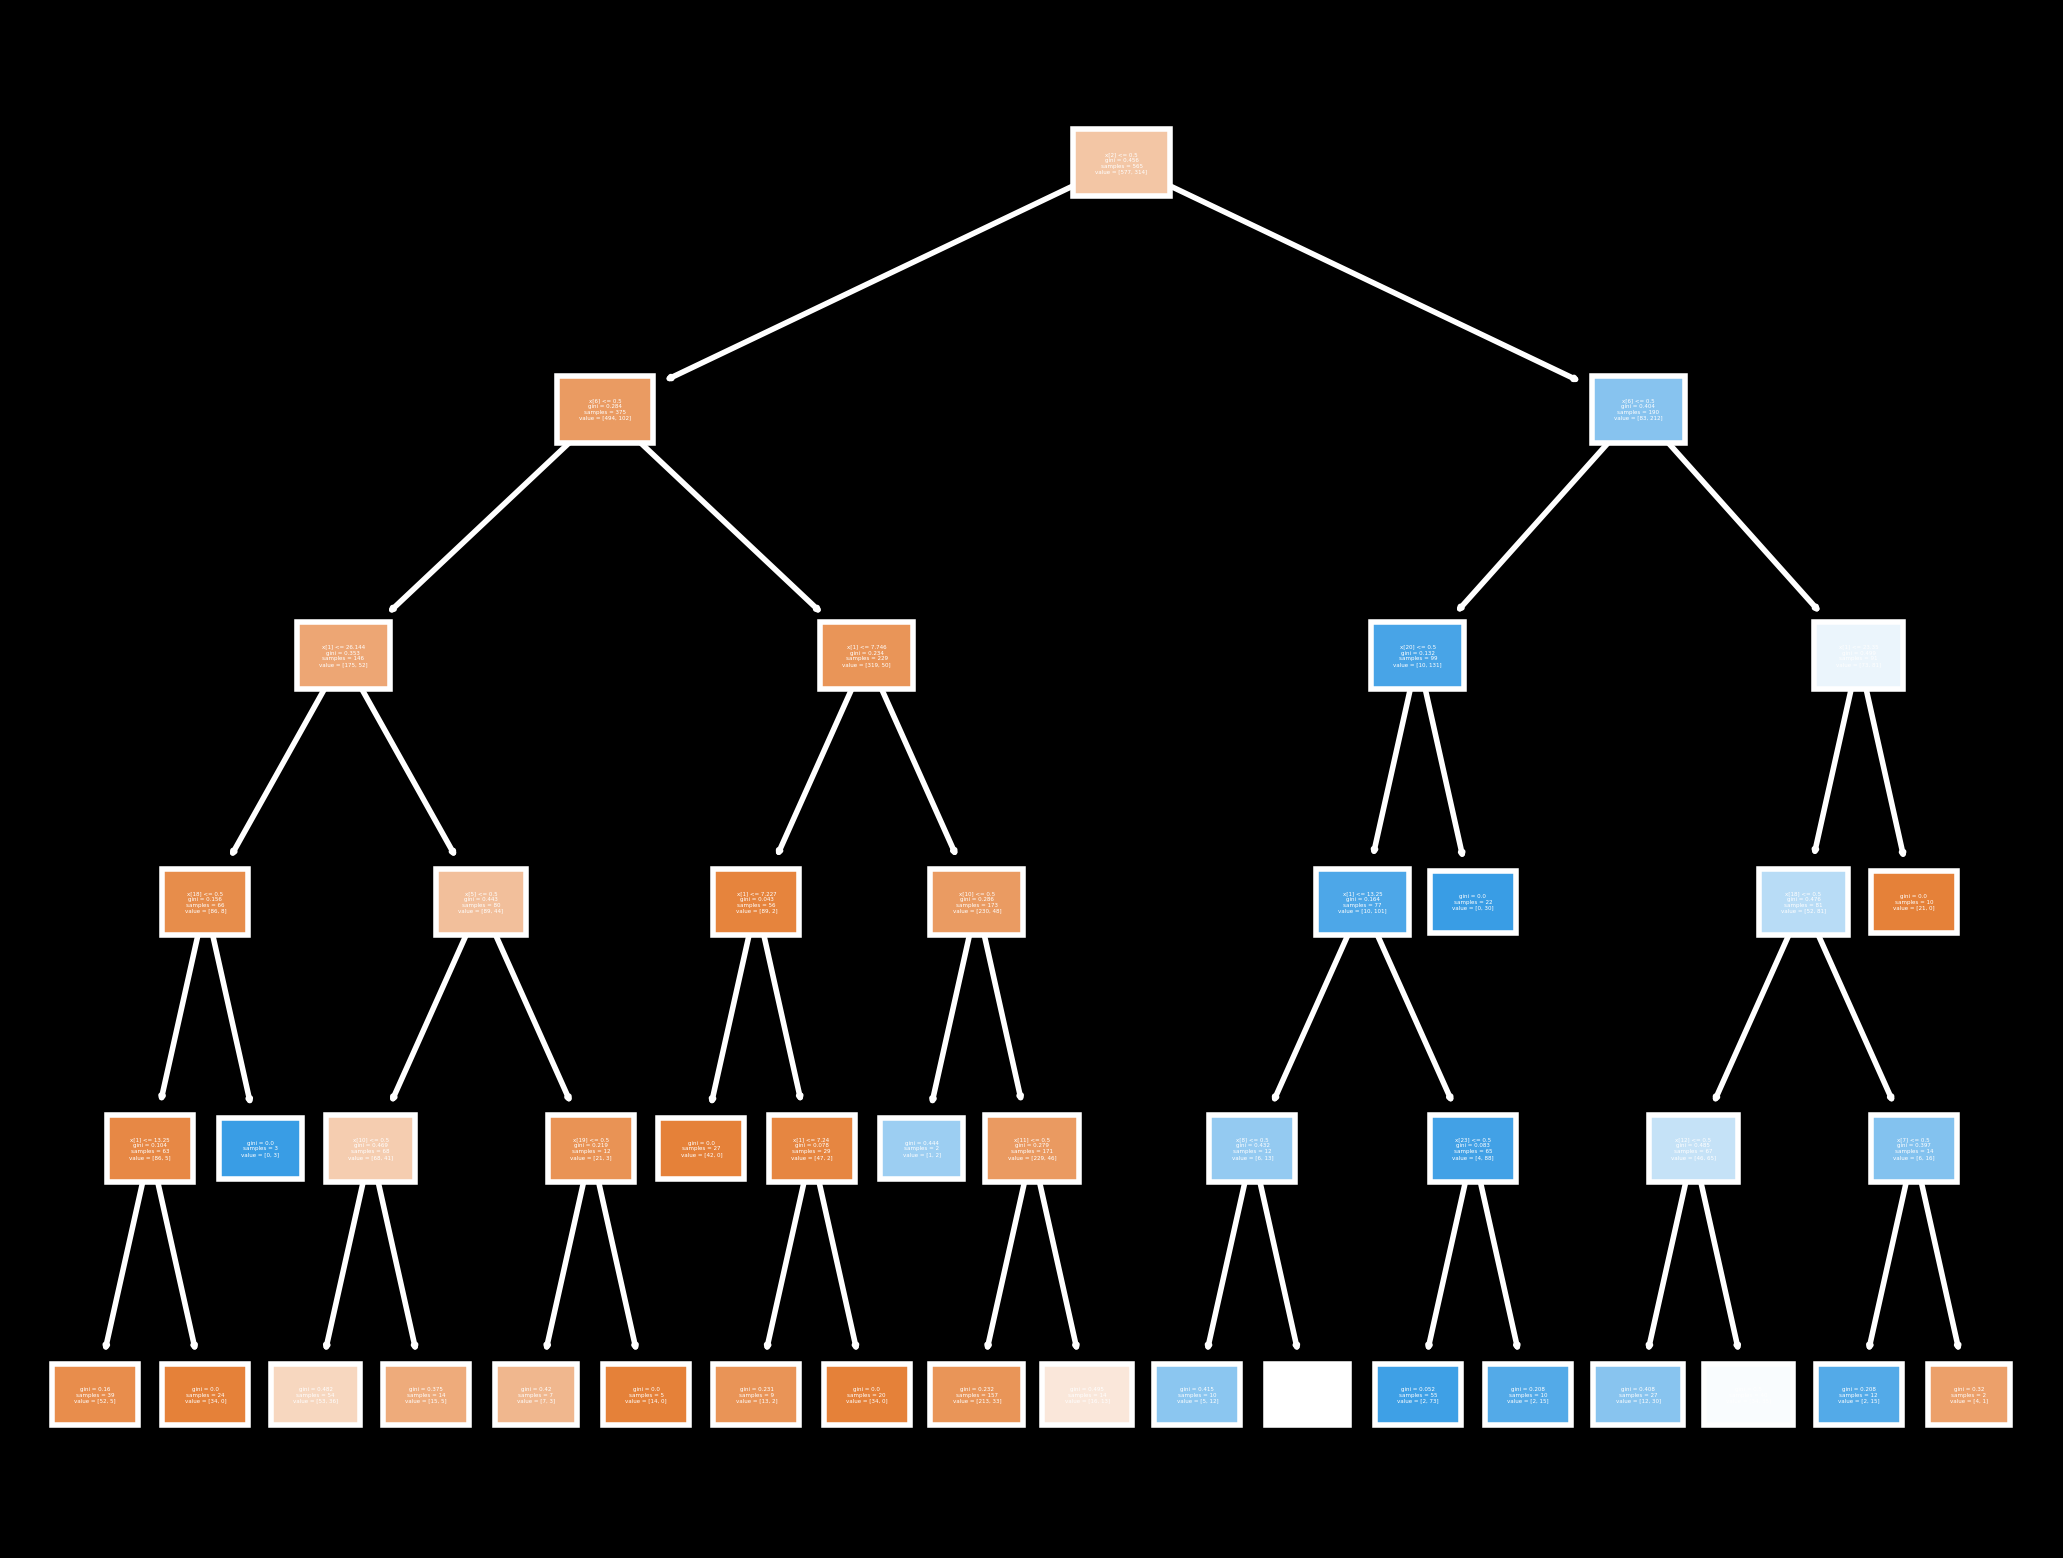

In [180]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(dpi=400)
plot_tree(RandomForest.estimators_[0], filled=True, fontsize=1)
plt.show()

## 2. Logistic regression

In [181]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train_dummies, y_train)
# predictions = LogReg.predict(X_test_dummies)

LogReg.score(X_test_dummies, y_test)

c:\ProgramData\miniconda3\envs\johannes\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8379888268156425

## 3. XGBoost

XGBoost doesn't like the commas in 'Ticket_d_(0, 100000]', 'Ticket_d_(100000, 200000]', 'Ticket_d_(200000, 300000]',...

In [182]:
X_train_dummies.columns

Index(['FamilySize', 'Fare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Cabin_prefix_AG', 'Cabin_prefix_BDE', 'Cabin_prefix_FG',
       'Cabin_prefix_Other', 'Embarked_C', 'Embarked_S', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'AgeGroup_Child',
       'AgeGroup_Teenager', 'AgeGroup_Adult', 'AgeGroup_Senior',
       'Ticket_d_(0, 100000]', 'Ticket_d_(100000, 200000]',
       'Ticket_d_(200000, 300000]', 'Ticket_d_(300000, 400000]',
       'Ticket_d_(400000, 3102000]'],
      dtype='object')

In [183]:
# Plot the decision tree

# plot_tree(bst, dpi=600)

# plt.show()

## 4. Support Vector Machines

In [184]:
from sklearn import svm
 
SVM = svm.SVC()
SVM.fit(X_train_dummies, y_train)

# predictions = SVM.predict(X_test_dummies)

SVM.score(X_test_dummies, y_test)

0.6480446927374302

In [185]:
pred_real = SVM.predict(X_result)

In [186]:
from datetime import datetime

timestamp  = datetime.now().strftime('%H%M%S')

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred_real})
output.to_csv(f'titanic/submission_SVM_{timestamp}.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## 4. Decision trees

To keep it close to what i learned to do.

In [187]:
from sklearn import tree

TREE = tree.DecisionTreeClassifier()
TREE.fit(X_train_dummies, y_train)
predictions = TREE.predict(X_test_dummies)

TREE.score(X_test_dummies, y_test)

0.8268156424581006

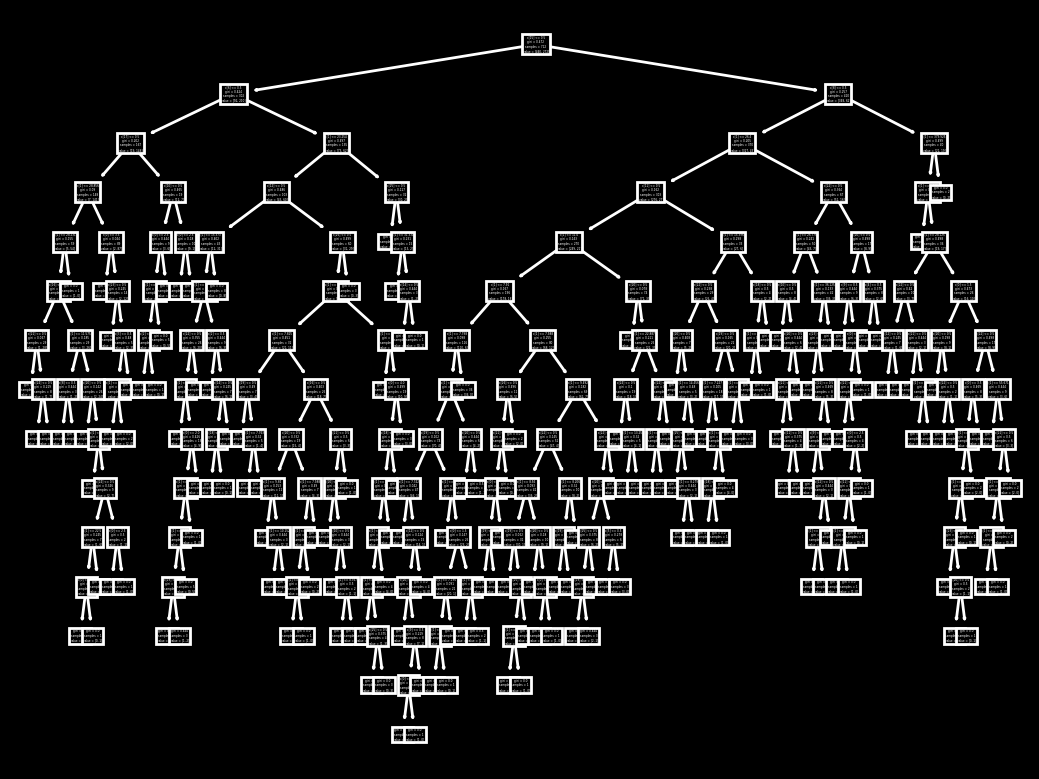

In [188]:
plt.figure(dpi=200)
tree.plot_tree(TREE)
plt.show()

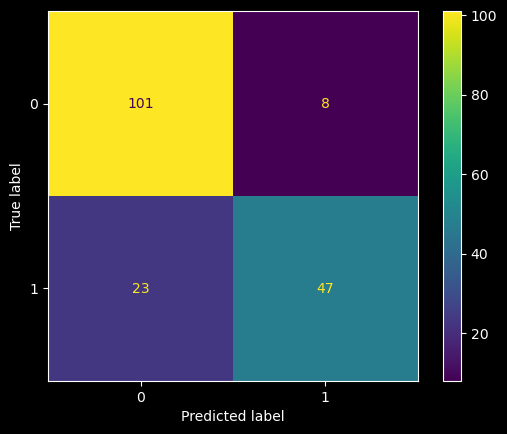

In [189]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Confusion matrix
```
[[true negative, false positive],
[false negative, true positive]]
```

## Aside: Johannes's on board

In [190]:
# train['Name_'] = train['Name'].str.extract(r'(Mr)')
# train.drop('Name_', axis=1)
# train.drop('Cabin_', axis=1)

In [191]:
train[train['Name'].str.contains(pat=r'Johannes ')] # note the space here

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,Cabin_prefix,Cabin_nr,FamilySize,fam_size,Ticket_,Ticket_d
652,653,0,3,"Kalvik, Mr. Johannes Halvorsen",male,21.0,0,0,8475,8.4333,<NA>,S,Mr,Teenager,Other,<NA>,1,single,8475.0,"(0, 100000]"
752,753,0,3,"Vande Velde, Mr. Johannes Joseph",male,33.0,0,0,345780,9.5000,<NA>,S,Mr,Adult,Other,<NA>,1,single,345780.0,"(300000, 400000]"


In [192]:
pd.__version__

'1.5.3'

In [193]:
! pip freeze

absl-py==1.4.0
aiohttp==3.8.4
aiosignal==1.3.1
altair==4.2.2
antlr4-python3-runtime==4.9.3
anyio==3.6.2
argilla==1.6.0
asgiref==3.6.0
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-timeout==4.0.2
async-tio==1.3.2
attrs==23.1.0
Automat==22.10.0
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backoff==2.2.1
beautifulsoup4 @ file:///C:/b/abs_0agyz1wsr4/croot/beautifulsoup4-split_1681493048687/work
blinker==1.6.2
boltons @ file:///C:/b/abs_707eo7c09t/croot/boltons_1677628723117/work
Bottleneck @ file:///C:/Windows/Temp/abs_3198ca53-903d-42fd-87b4-03e6d03a8381yfwsuve8/croots/recipe/bottleneck_1657175565403/work
brotlipy==0.7.0
cachetools==5.3.1
certifi @ file:///C:/b/abs_4a0polqwty/croot/certifi_1683875377622/work/certifi
cffi @ file:///C:/b/abs_49n3v2hyhr/croot/cffi_1670423218144/work
charset-normalizer @ file:///tmp/build/80754af9/charset-normalizer_1630003229654/work
chromadb==0.3.21
click==8.1.3
clickhouse-connect==0.5.22
c

In [195]:
! conda list

# packages in environment at C:\ProgramData\miniconda3\envs\johannes:
#
# Name                    Version                   Build  Channel
absl-py                   1.4.0                    pypi_0    pypi
aiohttp                   3.8.4                    pypi_0    pypi
aiosignal                 1.3.1                    pypi_0    pypi
altair                    4.2.2                    pypi_0    pypi
antlr4-python3-runtime    4.9.3                    pypi_0    pypi
anyio                     3.6.2                    pypi_0    pypi
argilla                   1.6.0                    pypi_0    pypi
asgiref                   3.6.0                    pypi_0    pypi
asttokens                 2.0.5              pyhd3eb1b0_0  
astunparse                1.6.3                    pypi_0    pypi
async-timeout             4.0.2                    pypi_0    pypi
async-tio                 1.3.2                    pypi_0    pypi
attrs                     23.1.0                   pypi_0    pypi
automat  